# Определение возраста покупателей

В данном задании нам неоходиом разработать нейронную сеть для определения возраста человека по его фотографии. Перед непосредстенно написанием скрипта - познакомимся с данными. Решать будем задачу регрессии, так как возраст это численное значение.

## Исследовательский анализ данных

In [1]:
#Импортируем необходимые для исследования библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [2]:
#Создадим dataframe и прочитаем данные:
df=pd.read_csv('/datasets/faces/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
#Узнаем размерность и проверим нет ли аномалий
df.shape

(7591, 2)

In [5]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f99f6ccf6d0>]],
      dtype=object)

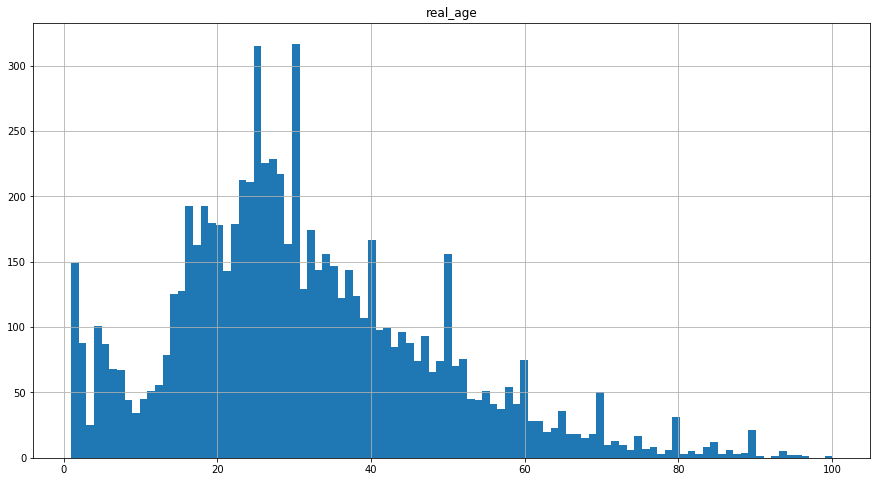

In [6]:
df.hist(bins=100,figsize=(15,8))

Давайте посмотрим на аномальные фотографии, а именно: посмотрим фотографии долгожителей (5шт), людей возрастом от 1 года(5шт), и несколько фотографий выберем рандомно(5шт)

In [7]:
#Создадим выборку из 5 фотографий возратсом до 5 лет
sorted_df=df.sort_values(by='real_age')

#Cоздадим список названий файлов до 5ти лет
before_5=(sorted_df.head(5))

#Создадим список названий файлов выбранных рандомно
random_age=(sorted_df.sample(5))

#Cоздадим список названий файлов до 100ти лет
before_100=(sorted_df.tail(5))

In [14]:
def print_photo(df):
    fig = plt.figure(figsize=(8,8)) #задавая размер всего вывода, каждое фото будет пропорционально изменяться
    for file in range(len(df)):
        file_name = list(df['file_name'])
        age = list(df['real_age'])
        image = Image.open('/datasets/faces/final_files/' + file_name[file])
        array = np.array(image)
        #Строим изображения
        fig.add_subplot(2, 3, file+1)
        plt.imshow(array)
        plt.title('Возраст: ' + str(age[file]))
        plt.tight_layout()

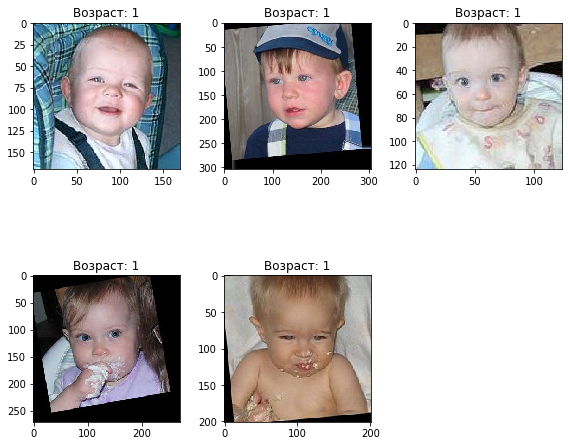

In [10]:
print_photo(before_5)

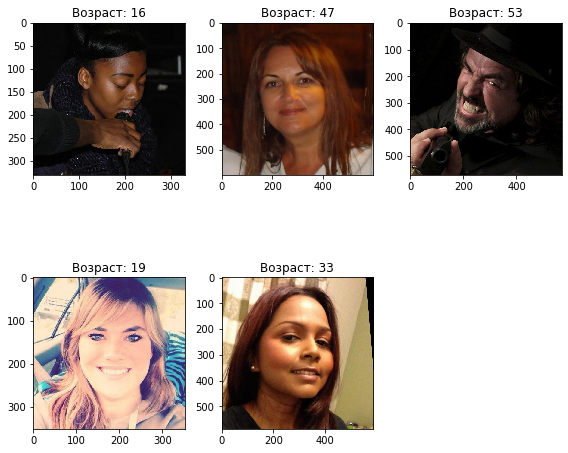

In [11]:
print_photo(random_age)

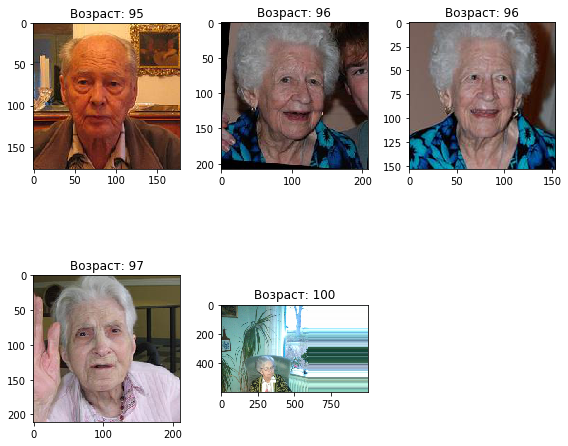

In [12]:
print_photo(before_100)

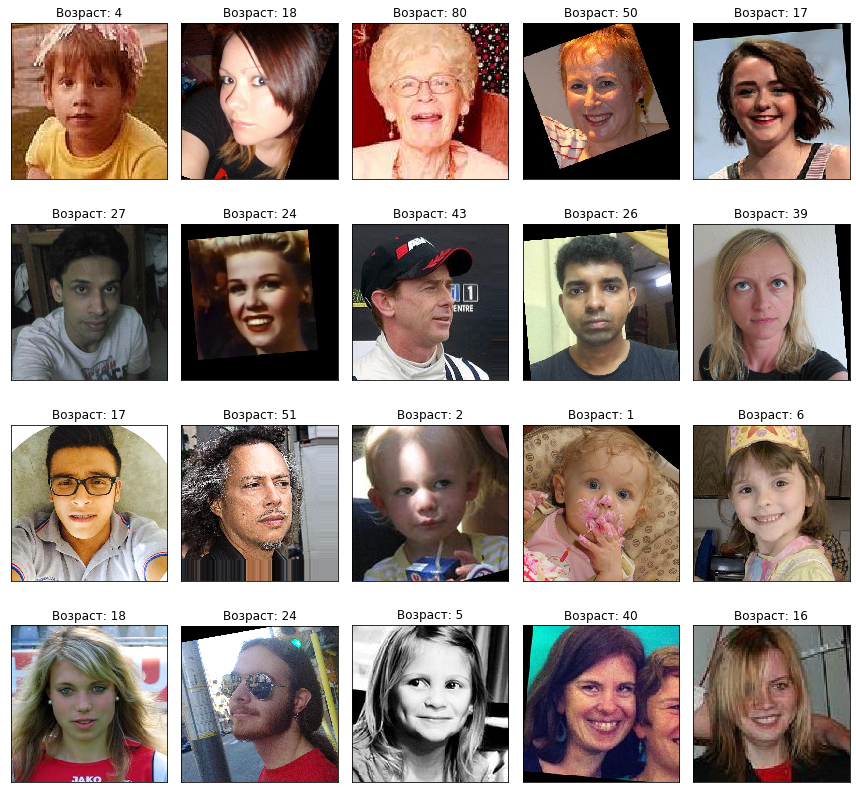

In [13]:
fig = plt.figure(figsize=(12,12))
for file in range(20):
    file_name = list(df['file_name'])
    age = list(df['real_age'])
    image = Image.open('/datasets/faces/final_files/' + file_name[file])
    array = np.array(image)
    #Строим изображения
    fig.add_subplot(4, 5, file+1)
    plt.imshow(array)
    plt.title('Возраст: ' + str(age[file]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**
В нашей выборке нет пропущенных значений. Данные распределены нормально, оданко можно заметить, что больше всего участников возрастом от 20 до 30 лет. Медиана:29, Среднее:31, почти нет смещения. Судя по распределению у нас мало фотографий людей старшего возраста (60+). Следовательно наша модель может плохо научиться определять возраст в данном диапазоне, так как данных может оказаться недостаточно. На каждой круглой дате видны всплески количества фотографий, возможно это как-то связано с тем, что люди фотографируются больше в свой кргулый возраст (юбилеи). 

Размерность, качество и цвета разнятся, так же далеко не всегда съемка портретная, часто завален горизонт или сами фото повернуты.

Из всего вышесказанного следует, что лучше всего пользоваться пространственными аугментациями, т.е. горизонтальный флип или повороты на небольшие углы. Так аугменты будут максимально естесственны.

У нас в выборке 7591 фотография. Выборка недостаточная для нашего обучения при условии, что мы воспользуемся предобученной сетью с архитекутрой ResNet50. Поэтому мы будем пошагово добавлять аугменты до тех пор пока не достигнем бейзлайна.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

if __name__ == "__main__":
    train_data = load_train("/datasets/faces/final_files/")
    test_data = load_test("/datasets/faces/final_files/")
    model = create_model(train_data[0].shape[1:])
    model = train_model(model, train_data, test_data)
    loss, metric = model.evaluate(test_data[0], test_data[1], verbose=2)
    print("Model: {:5.2f}%".format(100 * metric))

```

```

2021-11-07 12:13:00.375802: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-11-07 12:13:00.377907: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-11-07 12:13:01.920790: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-07 12:13:02.620952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-07 12:13:02.621065: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-07 12:13:02.621099: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-07 12:13:02.623025: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-11-07 12:13:02.623513: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-11-07 12:13:02.625902: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-11-07 12:13:02.627306: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-11-07 12:13:02.627405: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-11-07 12:13:02.632034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-11-07 12:13:02.632454: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-11-07 12:13:02.640729: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2021-11-07 12:13:02.641275: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x476a7c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-07 12:13:02.641312: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-07 12:13:02.802767: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x47f07e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-11-07 12:13:02.802830: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2021-11-07 12:13:02.805922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-07 12:13:02.806058: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-07 12:13:02.806075: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-07 12:13:02.806130: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-11-07 12:13:02.806168: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-11-07 12:13:02.806191: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-11-07 12:13:02.806207: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-11-07 12:13:02.806221: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-11-07 12:13:02.811916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-11-07 12:13:02.812086: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-07 12:13:03.178112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-07 12:13:03.178207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-11-07 12:13:03.178216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-11-07 12:13:03.182857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2021-11-07 12:13:21.548328: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-07 12:13:22.049821: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 128s - loss: 207.9602 - mae: 10.9180 - val_loss: 369.5447 - val_mae: 14.3485
Epoch 2/20
356/356 - 43s - loss: 134.4403 - mae: 8.8198 - val_loss: 228.0209 - val_mae: 11.1740
Epoch 3/20
356/356 - 43s - loss: 113.3025 - mae: 8.1800 - val_loss: 212.6387 - val_mae: 10.6578
Epoch 4/20
356/356 - 42s - loss: 92.8083 - mae: 7.3278 - val_loss: 122.7373 - val_mae: 8.6032
Epoch 5/20
356/356 - 43s - loss: 82.3430 - mae: 6.8966 - val_loss: 111.5403 - val_mae: 8.3377
Epoch 6/20
Epoch 7/20
356/356 - 43s - loss: 68.3665 - mae: 6.3532 - val_loss: 230.7129 - val_mae: 12.0595
356/356 - 42s - loss: 57.5252 - mae: 5.8245 - val_loss: 110.9144 - val_mae: 7.6919
Epoch 8/20
356/356 - 42s - loss: 49.2849 - mae: 5.4126 - val_loss: 128.8131 - val_mae: 8.5563
Epoch 9/20
356/356 - 41s - loss: 39.6713 - mae: 4.8672 - val_loss: 146.4403 - val_mae: 9.1745
Epoch 10/20
356/356 - 41s - loss: 36.1698 - mae: 4.6351 - val_loss: 96.5703 - val_mae: 7.2961
Epoch 11/20
356/356 - 39s - loss: 29.5993 - mae: 4.1962 - val_loss: 89.8018 - val_mae: 7.1706
Epoch 12/20
356/356 - 39s - loss: 29.1617 - mae: 4.1801 - val_loss: 106.0332 - val_mae: 8.0150
Epoch 13/20
356/356 - 39s - loss: 25.5688 - mae: 3.8998 - val_loss: 102.9710 - val_mae: 7.6990
Epoch 14/20
356/356 - 40s - loss: 25.4185 - mae: 3.8665 - val_loss: 102.4791 - val_mae: 7.9294
Epoch 15/20
356/356 - 41s - loss: 22.4953 - mae: 3.6681 - val_loss: 83.8297 - val_mae: 6.9316
Epoch 16/20
356/356 - 42s - loss: 19.5318 - mae: 3.4059 - val_loss: 101.6691 - val_mae: 7.5654
Epoch 17/20
356/356 - 43s - loss: 17.6756 - mae: 3.2560 - val_loss: 98.3362 - val_mae: 7.6038
Epoch 18/20
356/356 - 42s - loss: 20.0274 - mae: 3.4131 - val_loss: 91.2180 - val_mae: 7.1563
Epoch 19/20
356/356 - 42s - loss: 19.0923 - mae: 3.3453 - val_loss: 85.4482 - val_mae: 6.9399
Epoch 20/20
356/356 - 43s - loss: 16.3097 - mae: 3.0916 - val_loss: 97.3422 - val_mae: 7.3929
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 97.3422 - mae: 7.3929
Test MAE: 7.3929


```

## Анализ обученной модели

В первую очередь заметно, что модель переобучена, тем не менее мы достигли оптимального для нас значения. Местами на валидационной выборке видно что значение mae снижается ниже 7ми. Я вижу два варианта улучшения ситуации:

1) Поэксперементировать с количеством полносвязных слоев, а так же функциями активации.

2) Поработать с набором данных, увеличить количество фотографий дефицитных возрастов и привести выборку к равномерному распределению. Поработать с аугментацией.

Скорее всего совокупность вышеперечисленных пунктов обеспечат уменьшение ключейвой метрики, а следовательно и качество работы модели.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы